<a href="https://colab.research.google.com/github/Hansika2424/Crop-leaf-disease-detection-using-Deep-Learning/blob/main/Crop_leave_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

seeding for reproductibility

In [ ]:
#Setting seed for reproductibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)


Importing the dependencies


In [ ]:
import os # to access files
import json # to load kaggle.json file
from zipfile import ZipFile # dataset will be installed in zip file when we call dataset API from kaggle
from PIL import Image #image processing
import numpy as np #
import matplotlib.pyplot as plt # to plot graphs and images
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator # datapipelines that we will set for training and testing data
from tensorflow.keras import layers, models # layers used to have all the layers convolutional layers, flattening layers, dense layers
                                            # models -> we'll import our sequential data from models.




In [ ]:
import os
print(os.listdir())  # Shows all files in current directory
print(os.getcwd())   # Shows current working directory

['.config', 'sample_data']
/content


In [ ]:
kaggle_credentials = json.load(open('kaggle (1).json'))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Download dataset

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [00:17<00:00, 94.0MB/s]
100% 2.04G/2.04G [00:17<00:00, 125MB/s] 


In [ ]:
!ls


 drive	'kaggle (1).json'   plantvillage-dataset.zip   sample_data


#unzip the dataset

In [ ]:
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
  zip_ref.extractall()

dataset exploration


In [ ]:
print(os.listdir("plantvillage dataset"))

print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

['grayscale', 'color', 'segmented']
38
['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Strawberry___Leaf_scorch', 'Tomato___Late_blight', 'Grape___healthy', 'Corn_(maize)___healthy']
38
['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Strawberry___Leaf_scorch', 'Tomato___Late_blight', 'Grape___healthy', 'Corn_(maize)___healthy']
38
['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Strawberry___Leaf_scorch', 'Tomato___Late_blight', 'Grape___healthy', 'Corn_(maize)___healthy']


# Data Preparation and Image Augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Directory path
data_dir = "plantvillage dataset/color"

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)



Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


# Model Building using Pre-Trained MobileNet + Custom layers


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load base MobileNet (excluding the final classifier layers)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,364,966 (12.84 MB)

 Trainable params: 136,102 (531.65 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

# Model Training


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_mobilenet_model.keras', monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint]
)


Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2867 - loss: 2.9334
Epoch 1: val_accuracy improved from -inf to 0.78365, saving model to best_mobilenet_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2721s 2s/step - accuracy: 0.2868 - loss: 2.9329 - val_accuracy: 0.7836 - val_loss: 0.8823
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6405 - loss: 1.2535
Epoch 2: val_accuracy improved from 0.78365 to 0.87353, saving model to best_mobilenet_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2702s 2s/step - accuracy: 0.6405 - loss: 1.2534 - val_accuracy: 0.8735 - val_loss: 0.4717
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7384 - loss: 0.8555
Epoch 3: val_accuracy improved from 0.87353 to 0.90201, saving model to best_mobilenet_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2860s 2s/step - accuracy: 0.7384 - loss: 0.8555 - val_accuracy: 0.9020 - val_loss: 0.3407
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7863 - loss: 0.6924

# Evaluation Metrics


In [ ]:
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Evaluating model...
339/339 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.9378 - loss: 0.2174
Validation Accuracy: 92.43%


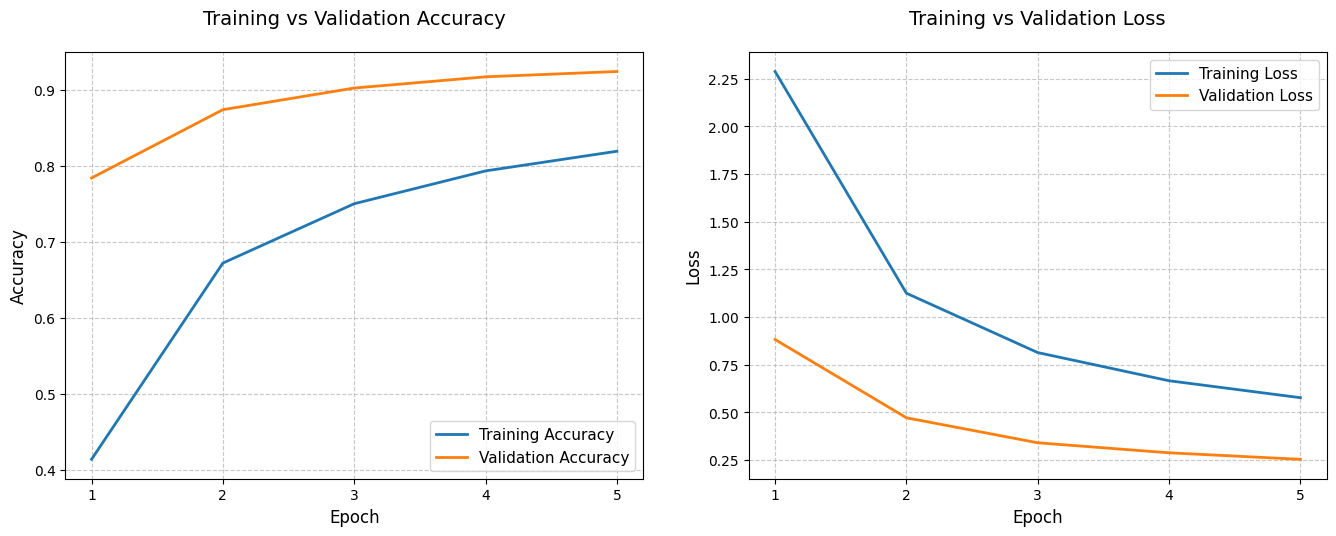

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)  # Starting from epoch 1

# Create figure with two subplots
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Validation Accuracy', fontsize=14, pad=20)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs_range)  # Show all epoch numbers on x-axis

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=14, pad=20)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs_range)  # Show all epoch numbers on x-axis

# Adjust layout and display
plt.tight_layout(pad=3.0)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Get predictions
Y_pred = model.predict(val_generator, steps=val_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())


340/340 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step


In [ ]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.81      0.86       126
                                 Apple___Black_rot       0.97      0.90      0.93       124
                          Apple___Cedar_apple_rust       0.98      0.85      0.91        55
                                   Apple___healthy       0.92      0.96      0.94       329
                               Blueberry___healthy       0.99      0.99      0.99       300
          Cherry_(including_sour)___Powdery_mildew       0.99      0.97      0.98       210
                 Cherry_(including_sour)___healthy       0.98      0.94      0.96       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.64      0.74       102
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       238
               Corn_(maize)___Northern_Leaf_Blight     

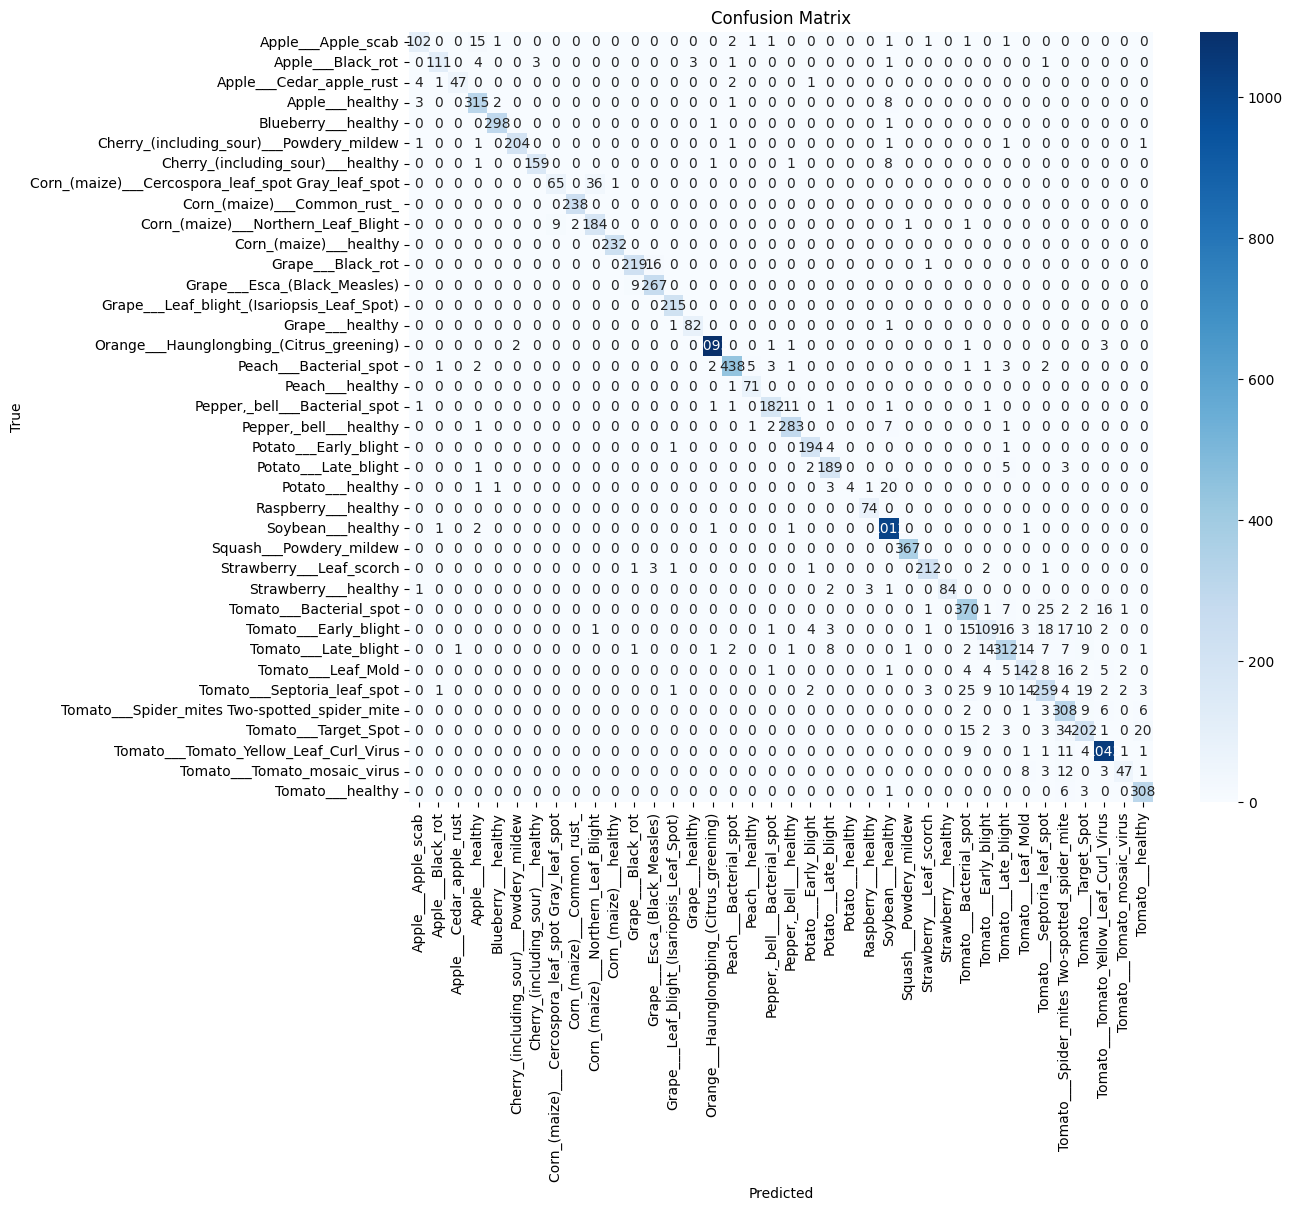

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Building a Prediction System


In [ ]:
import numpy as np
from PIL import Image
import os
import tensorflow as tf

# 1. Load & preprocess image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Loads an image from disk, resizes, scales, and reshapes it for prediction.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0
    return img_array

# 2. Predict class
def predict_image_class(model, image_path, class_indices):
    """
    Takes a trained model, image path, and class indices mapping to return predicted class.
    """
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Reverse mapping from class_indices
    index_to_class = {v: k for k, v in class_indices.items()}
    predicted_class_name = index_to_class[predicted_class_index]

    return predicted_class_name


In [ ]:
# Load your trained model
model = tf.keras.models.load_model('best_mobilenet_model.keras')

# Get class indices from your generator
class_indices = train_generator.class_indices

# Path to a test image
test_image_path = "/content/apple_scab_test.JPG"


# Predict
predicted_class = predict_image_class(model, test_image_path, class_indices)
print("Predicted Disease Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicted Disease Class: Apple___Apple_scab
